# synthetic validation


## 1. Real photocurrent, real PSCs

In [1]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt


import subtractr
import subtractr.photocurrent_sim as pcsim
import jax.random as jrand

import circuitmap as cm
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.gridspec import GridSpec
from subtractr import utils
from functools import partial
from jax import vmap

In [3]:


# load datset with no photocurrents
pscs, stim_mat, powers, targets = utils.load_h5_data('../data/marta/ai203/preprocessed/201118_cell1_A_cmFormat.mat')

# load subtractr net
subtractr_checkpoint = './grid_artifacts/cunning-brattain-9345/cunning-brattain-9345-exp0/scripts/lightning_logs/version_0/checkpoints/epoch=127-step=360063.ckpt'

net = cm.NeuralDemixer(
    path=subtractr_checkpoint,
    unet_args=dict(
            down_filter_sizes=(16, 32, 64, 128),
            up_filter_sizes=(64, 32, 16, 4),
    ))

# load demixer
demixer_checkpoint = '../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt'
demixer = cm.NeuralDemixer(
    path=demixer_checkpoint,
)

In [11]:
from scipy.stats import multivariate_normal


def make_spatial_opsin_resp(targets,
    powers,
    stim_mat,
    phi_0=0.1,
    phi_1=35):

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    unique_powers = np.unique(powers)
    unique_tars = np.unique(targets, axis=0)

    num_xs = len(np.unique(unique_tars[:,0]))
    num_ys = len(np.unique(unique_tars[:,1]))
    num_zs = len(np.unique(unique_tars[:,2]))

    opsin_resp_centroid = np.mean(unique_tars, axis=0)
    opsin_resp_cov = np.diag([150, 150, 400])
 
    rv = multivariate_normal(opsin_resp_centroid, opsin_resp_cov)

    opsin_resp = np.zeros(stim_mat.shape[1])
    for trial in range(stim_mat.shape[1]):
        neurons_this_trial = np.where(stim_mat[:, trial])[0]
        for neuron_idx in neurons_this_trial:
            xyz = targets[neuron_idx]
            p = powers[trial]
            opsin_resp[trial] += rv.pdf(xyz) * phi_0 * sigmoid(p - phi_1)

    opsin_resp /= np.max(opsin_resp)
    return opsin_resp

def make_hybrid_dataset(key,
    pscs,
    targets,
    stim_mat,
    templates_path=None,
    opsin_std_dev=0.1,
    pc_shape_params=None,
    onset_latency_ms=0.0,
    onset_jitter_ms=0.2):

    if pc_shape_params is None:
        pc_shape_params = dict(
           O_inf_min=0.3,
            O_inf_max=1.0,
            R_inf_min=0.3,
            R_inf_max=1.0,
            tau_o_min=3,
            tau_o_max=3,
            tau_r_min=3,
            tau_r_max=3, 
        )

    # grab photocurrent shape from templates
    if templates_path is not None:
        with h5py.File(templates_path) as F:
            templates = np.array(F['traces'])

        photocurrent_waveforms = np.squeeze(
            subtractr.photocurrent_sim.sample_from_templates(
                templates,
                key,
                size=1,
            )
        )
    else:
        # sample a bunch of photocurrent waveforms with the same shape,
        # but with slight jitter
        photocurrent_waveforms = pcsim.sample_jittered_photocurrent_shapes(
            key,
            num_traces=pscs.shape[0],
            pc_shape_params = pc_shape_params,
        )[0]
        
        

    # create spatial opsin response
    average_opsin_resp = make_spatial_opsin_resp(targets, powers, stim_mat) * 0.8

    # sample from normal modulated by space and power
    opsin_scales = np.random.normal(loc=average_opsin_resp, scale=opsin_std_dev)

    # be lazy instead of sampling from truncated normal distribution
    # shouldn't matter too much here
    opsin_scales = np.maximum(0, opsin_scales)
    scaled_photocurrents = photocurrent_waveforms * opsin_scales[:,None]

    pscs_plus_photo = pscs + scaled_photocurrents

    import pdb; pdb.set_trace()
    return pscs_plus_photo, scaled_photocurrents, photocurrent_waveforms


In [5]:


pscs, stim_mat, powers, targets = utils.load_h5_data('../data/marta/ai203/preprocessed/201119_cell7_A_cmFormat.mat')
pscs = -pscs
psc_tensor = utils.make_psc_tensor_multispot(pscs, powers, targets, stim_mat)



In [12]:


key = jrand.PRNGKey(1)

# grab photocurrent shape from templates
templates_path = 'pc_examples_fastdecay.h5'
pscs_plus_photo, scalled_photocurrents, photocurrent_waveform = make_hybrid_dataset(
    key, pscs, targets, stim_mat, templates_path=None,
)


> /var/folders/67/j86q1s2s1_dg5m568j2k9d040000gn/T/ipykernel_21223/2459789976.py(95)make_hybrid_dataset()
     91 
     92     pscs_plus_photo = pscs + scaled_photocurrents
     93 
     94     import pdb; pdb.set_trace()
---> 95     return pscs_plus_photo, scaled_photocurrents, photocurrent_waveforms

(81120, 900)
(3, 81120, 900)
*** AttributeError: 'tuple' object has no attribute 'shape'
*** AttributeError: 'tuple' object has no attribute 'shape'
3


BdbQuit: 

In [10]:
pscs_plus_photo.shape

(3, 81120, 900)

In [9]:

combined_tensor = utils.make_psc_tensor_multispot(pscs_plus_photo, powers, targets, stim_mat)
combined_map = utils.traces_tensor_to_map(combined_tensor)
original_map = utils.traces_tensor_to_map(psc_tensor)


ValueError: could not broadcast input array from shape (81120,900) into shape (900,)

In [204]:
mt_net = subtractr.Subtractr.load_from_checkpoint('../subtractr/lightning_logs/version_494457/checkpoints/epoch=219-step=687500.ckpt')
ests = mt_net(pscs_plus_photo)
subtracted = pscs_plus_photo - ests
corrected_tensor = utils.make_psc_tensor_multispot(subtracted, powers, targets, stim_mat)
corrected_map = utils.traces_tensor_to_map(corrected_tensor)

Running photocurrent removal...complete (elapsed time 243.94s, device=cpu).


/var/folders/67/j86q1s2s1_dg5m568j2k9d040000gn/T/ipykernel_1803/4076900628.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


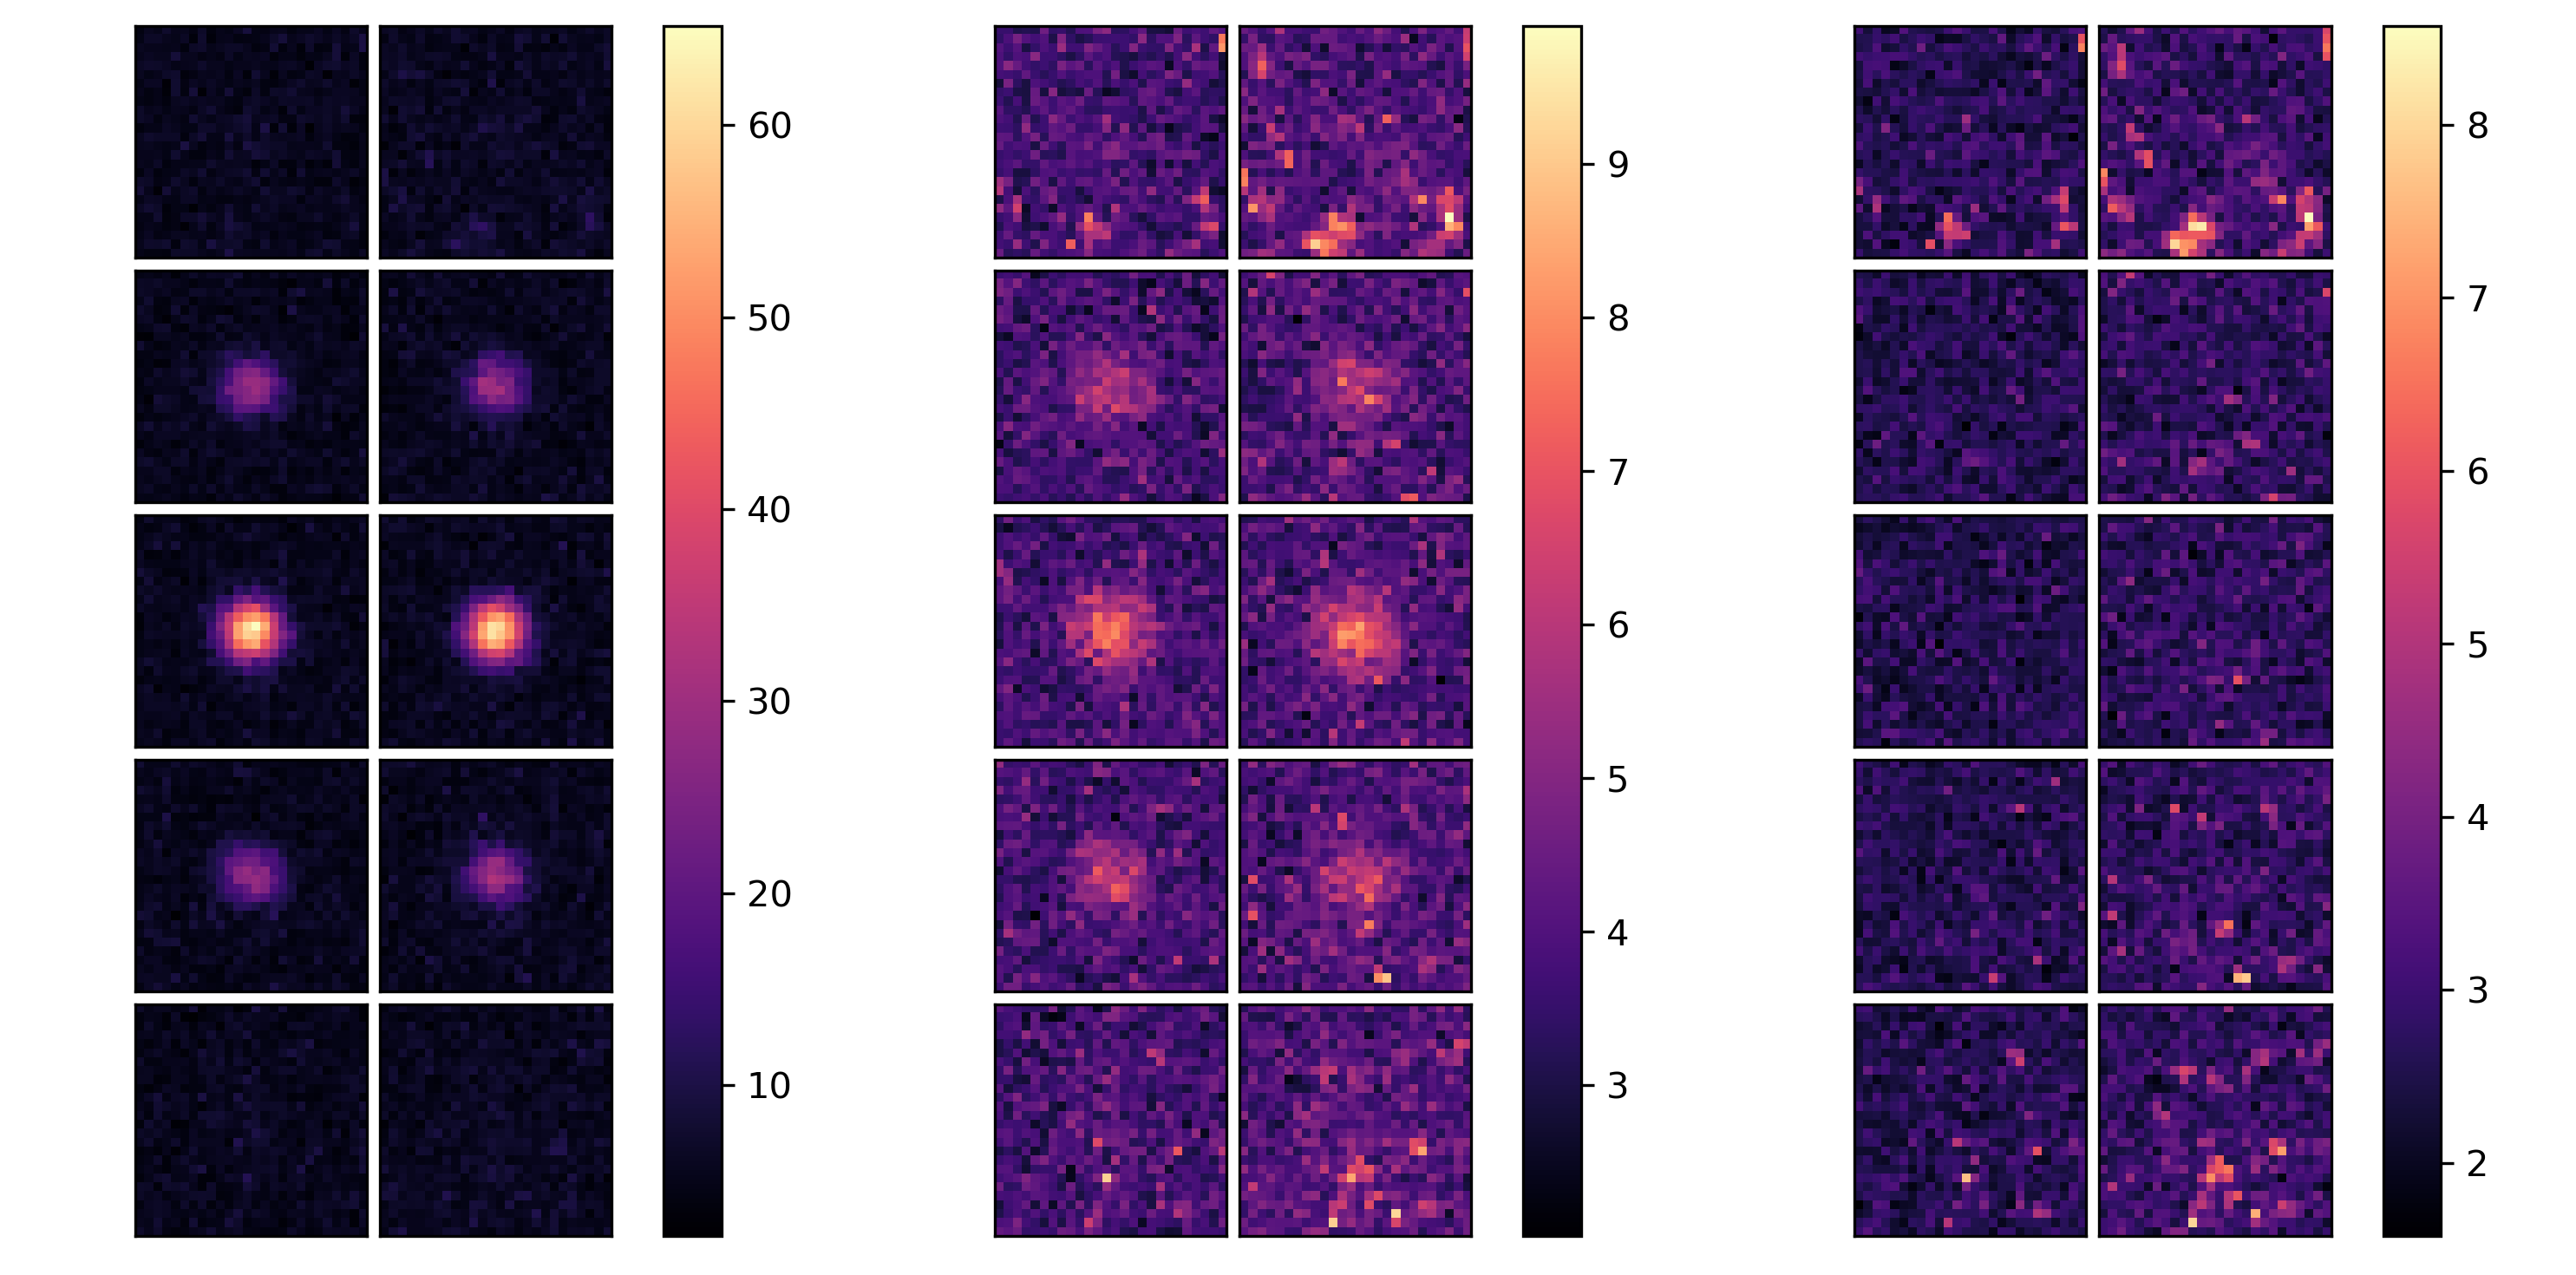

In [205]:
fig1 = plt.figure(figsize=(10, 5), dpi=300, facecolor='white')
utils.plot_multi_means(fig1,
    [combined_map, corrected_map, original_map], 
    np.arange(5),
    cmaps=['magma', 'magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    map_names=['corrupted', 'subtr.', 'g.t'],
    # vranges=[(0,15), (0,15), (0,15), (0,15)],
    show_powers=(True, True, True, True)
)
plt.tight_layout()

In [206]:
def plot_subtraction_synthetic(pscs, ests, subtracted, photocurrents, powers, time=None, fig_kwargs=None):

    if fig_kwargs is None:
        fig_kwargs = dict(
            figsize=(9,3), 
            dpi=200,
            sharex=True
        )
    unique_powers = np.unique(powers)
    fig, axs = plt.subplots(nrows=len(unique_powers), ncols = 4, squeeze=False, **fig_kwargs)

    if time is None:
        time = np.arange(0,900) * 0.05
    for i in range(len(unique_powers)):
        these_trials = (powers == unique_powers[i])
        these_pscs = pscs[these_trials]
        these_ests = ests[these_trials]
        these_subtracted = subtracted[these_trials]
        these_photocurrents = photocurrents[these_trials]

        # order each by magnitude of photocurrent
        ordered_idx = np.argsort(np.sum(these_pscs, axis=-1))[::-1]
        these_pscs = these_pscs[ordered_idx]
        these_ests = these_ests[ordered_idx]
        these_photocurrents = these_photocurrents[ordered_idx]

        these_subtracted = these_subtracted[ordered_idx]

        axs[i,0].plot(time, these_pscs[0:20].T)
        axs[i,1].plot(time, these_ests[0:20].T)
        axs[i,2].plot(time, these_photocurrents[0:20].T)
        axs[i,3].plot(time, these_subtracted[0:20].T)

        # make ylim of first two plots match
        axs[i,1].set_ylim(axs[i,0].get_ylim())
        axs[i,3].set_ylim(axs[i,2].get_ylim())
        axs[i,0].set_ylabel('%d mW' % unique_powers[i])

    labels = ['raw', 'est pc', 'true pc', 'subtracted']
    for i in range(4):
        axs[-1, i].set_xlabel('time (ms)')
        axs[0, i].set_title(labels[i])

    plt.tight_layout()
    return fig

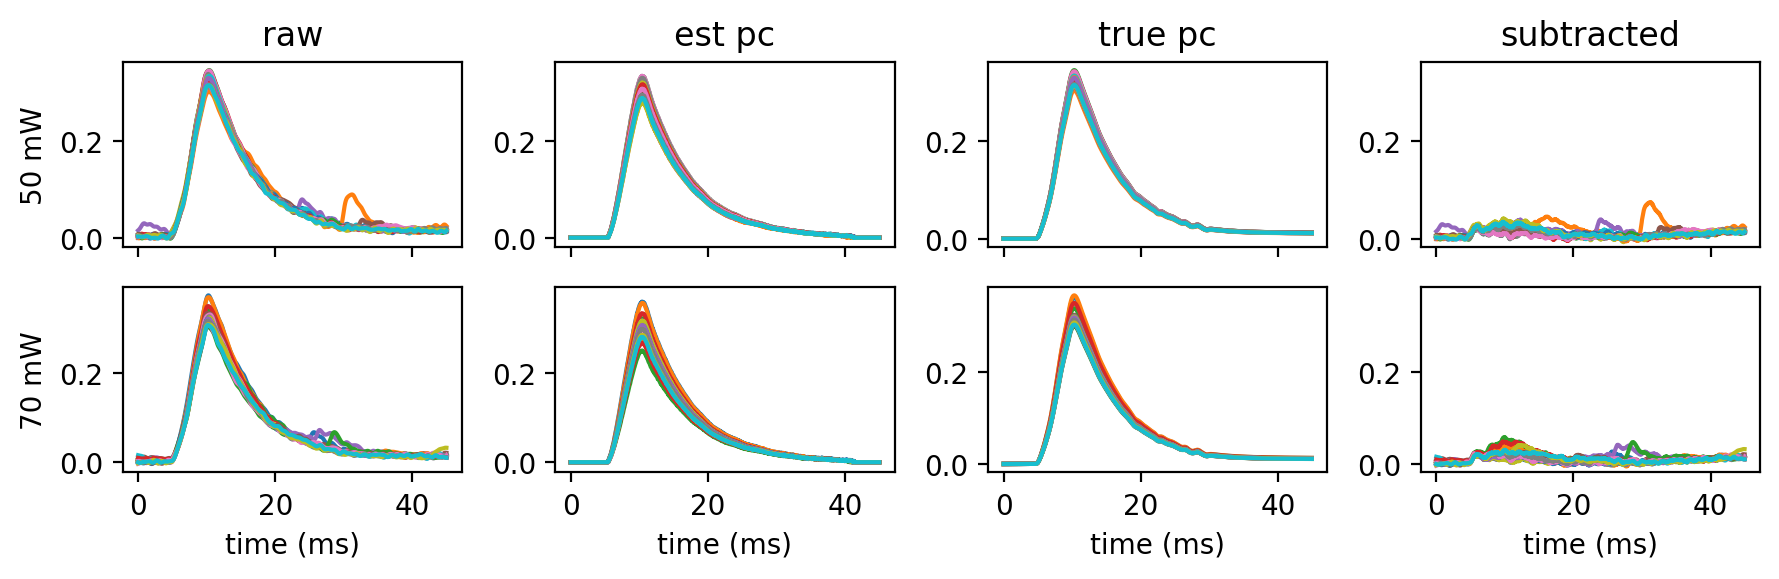

In [208]:
fig = plot_subtraction_synthetic(pscs_plus_photo, ests, subtracted,
    scalled_photocurrents, powers)

Demixing PSC traces... complete (elapsed time 0.03s, device=cpu).


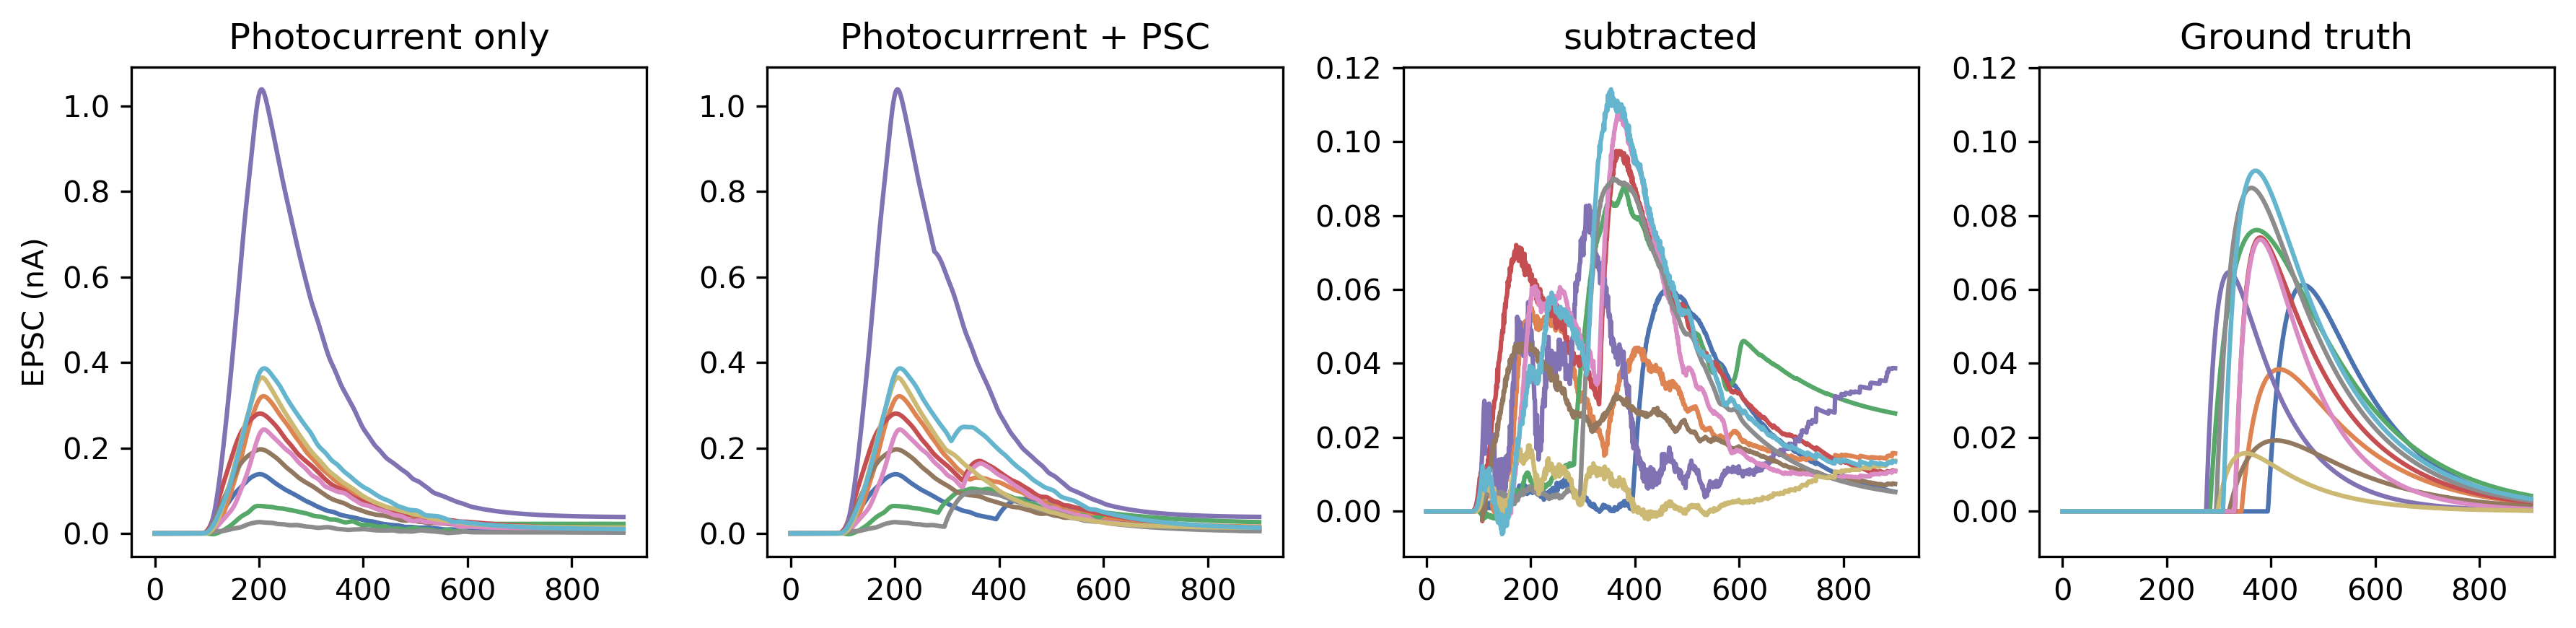

In [ ]:
import seaborn as sns
sns.set_palette('deep')

fig,  axs = plt.subplots(1, 4, figsize=(12,3), dpi=300, facecolor='white')

est = net(combined)
subtracted = combined - est

axs[0].plot(photocurrents.T)
axs[1].plot(combined.T)
axs[2].plot(subtracted.T)
axs[3].plot(pscs.T)
axs[3].set_ylim(axs[2].get_ylim())

axs[0].set_title('Photocurrent only')
axs[1].set_title('Photocurrrent + PSC')
axs[2].set_title('subtracted')
axs[3].set_title('Ground truth')
axs[0].set_ylabel('EPSC (nA)')
plt.tight_layout()
plt.show()

## Where during the trial do we tend to make errors?

In [ ]:
latencies = np.arange(160, 400, 10)

In [ ]:
mses = []
stds = []
for psc_latency in latencies:

    combined, photocurrents, pscs = make_hybrid_dataset(
        pc_examples,
        key,
        size=1000,
        sample_psc_kernel_kwargs=dict(
            delta_lower=psc_latency, delta_upper=psc_latency,
            amplitude_lower=0.01, amplitude_upper=0.2,)
    )

    est = net(combined)
    subtracted = combined - est
    errs = np.square(subtracted - pscs)
    per_trial_err = np.sum(errs, axis=-1)
    mse = np.mean(per_trial_err)
    std = np.std(per_trial_err)

    mses.append(mse)
    stds.append(std)


/Users/Bantin/anaconda3/envs/circuitmap/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Demixing PSC traces... complete (elapsed time 1.79s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.72s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.69s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.71s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.68s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.67s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.77s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.85s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.77s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.75s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.75s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.73s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.72s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.70s, device=cpu).
Demixing PSC traces... complete (elapsed time 1.68s, device=cpu).
Demixing P

<ErrorbarContainer object of 3 artists>

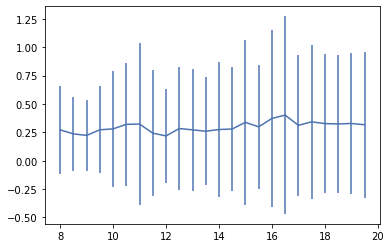

In [ ]:
plt.errorbar(latencies * 0.05, mses, stds, None)